<a href="https://colab.research.google.com/github/zwcrowley/module_21_deep_learning_challenge/blob/main/deep_learning_charity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project 4: Predicting Congressional Bill Passage**

# House Model: Machine Learning Optimization and Model Output

## Team 7


## Import dependencies and read in data:

In [14]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from keras.models import load_model
from keras.utils import plot_model
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [15]:
#  Import and read the cleaned house data from AWS S3:
house_df = pd.read_csv("https://raw.githubusercontent.com/JJERANEK/Project-4/main/Resources/house_cleaned.csv")
house_df.head()

,Bill Type,Congress,Number of Cosponsors,Cosponsor Dems,Cosponsor Reps,Cosponsor Ind,Cosponsor States,Committees,Latest Action,Subject,...,Housing and Community Development,Immigration,International Affairs,Labor and Employment,Native Americans,Public Lands and Natural Resources,"Science, Technology, Communications",Social Welfare,Transportation and Public Works,bill_passed
0,H.R.,0,200,200,0,0,46,"House - Judiciary, Energy and Commerce, Educat...",Referred to the Subcommittee on Higher Educati...,Accounting and auditing,...,0,0,0,0,0,0,0,0,0,0
1,H.R.,0,179,179,0,0,42,"House - House Administration, Judiciary, Scien...",Referred to the Subcommittee on Higher Educati...,Administrative law and regulatory procedures,...,0,0,0,0,0,0,0,0,0,0
2,H.R.,1,0,0,0,0,0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
3,H.R.,1,0,0,0,0,0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
4,H.R.,0,200,197,3,0,46,"House - Judiciary, Foreign Affairs, Homeland S...",Motion to Discharge Committee filed by Mr. Gar...,Administrative law and regulatory procedures,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Import from google drive folder:
# Mount google drive to get data:
from google.colab import drive
drive.mount('/content/gdrive')
# house_filepath = "/content/gdrive/MyDrive/DataClassNotebooks/Project-4/Resources/house_cleaned.csv"

# Read in senate data using pandas:
# house_df = pd.read_csv(house_filepath)
# Glimpse house data:
# house_df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### Building two ml models, one with House of Reps data and one with Senate Data

# House Model:

## Preprocessing

In [17]:
# Check for NAs, duplicates and get the shape of the data:
print(f'The shape of the house_df data is: {house_df.shape}')
print(f'The number of NAs in the house_df data: {house_df.isnull().sum()}')
print(f'The duplicate rows of NAs in the house_df data: {house_df.duplicated().sum()}')
# There are 41 columns, 40683 rows, and no NAs or duplicates in the house_df dataset.
# target is bill_passed

The shape of the house_df data is: (39071, 68)
The number of NAs in the house_df data: Bill Type                              0
Congress                               0
Number of Cosponsors                   0
Cosponsor Dems                         0
Cosponsor Reps                         0
                                      ..
Public Lands and Natural Resources     0
Science, Technology, Communications    0
Social Welfare                         0
Transportation and Public Works        0
bill_passed                            0
Length: 68, dtype: int64
The duplicate rows of NAs in the house_df data: 889


In [18]:
# Numeric variable stats
house_df.describe()

,Congress,Number of Cosponsors,Cosponsor Dems,Cosponsor Reps,Cosponsor Ind,Cosponsor States,Month Introduced,Agriculture,Appropriations,Armed Services,...,Housing and Community Development,Immigration,International Affairs,Labor and Employment,Native Americans,Public Lands and Natural Resources,"Science, Technology, Communications",Social Welfare,Transportation and Public Works,bill_passed
count,39071.000000,39071.000000,39071.000000,39071.000000,39071.000000,39071.000000,39071.000000,39071.000000,39071.000000,39071.000000,...,39071.000000,39071.000000,39071.000000,39071.000000,39071.000000,39071.000000,39071.000000,39071.000000,39071.000000,39071.000000
mean,0.035781,15.994958,10.077167,5.917560,0.000179,7.270917,5.526119,0.041949,0.014307,0.053416,...,0.010161,0.020808,0.021295,0.015561,0.007730,0.022523,0.018095,0.009393,0.023854,0.030176
std,0.185746,34.554614,25.365969,17.311754,0.013384,9.705441,3.272783,0.200476,0.118756,0.224864,...,0.100290,0.142744,0.144366,0.123773,0.087578,0.148379,0.133298,0.096463,0.152596,0.171073
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.000000,1.000000,1.000000,0.000000,3.000000,5.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,15.000000,8.000000,4.000000,0.000000,10.000000,8.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,386.000000,238.000000,244.000000,1.000000,58.000000,12.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
# Get the column names:
list(house_df.columns)


['Bill Type',
 'Congress',
 'Number of Cosponsors',
 'Cosponsor Dems',
 'Cosponsor Reps',
 'Cosponsor Ind',
 'Cosponsor States',
 'Committees',
 'Latest Action',
 'Subject',
 'Sponsor Title',
 'Sponsor Party',
 'Sponsor State',
 'Month Introduced',
 'Agriculture',
 'Appropriations',
 'Armed Services',
 'Budget',
 'Education and the Workforce',
 'Energy and Commerce',
 'Ethics',
 'Financial Services',
 'Foreign Affairs',
 'Homeland Security',
 'House Administration',
 'Judiciary',
 'Natural Resources',
 'Oversight and Accountability',
 'Rules',
 'Science, Space, and Technology',
 'Small Business',
 'Transportation and Infrastructure',
 "Veterans' Affairs",
 'Ways and Means',
 'Intelligence',
 'Printing',
 'Taxation',
 'Library',
 'Economic',
 'Accounting and auditing',
 'Administrative law and regulatory procedures',
 'Administrative remedies',
 'Advisory bodies',
 'Agriculture and Food',
 'Armed Forces and National Security',
 'Civil actions and liability',
 'Commerce',
 'Congressional

### Model Target:


*   "Latest Action" == "Became Public Law" is the target for the models



In [20]:
# Model Target:
house_df["bill_passed"].value_counts()
# 1179 bills  in the dataset which originated from the House became law in the 113th-117th Congresses

0    37892
1     1179
Name: bill_passed, dtype: int64

In [21]:
# Drop the non-beneficial columns: 'Unnamed' column.
house_df = house_df.drop(["Bill Type", "Subject", "Committees", "Latest Action" ], axis='columns')
house_df.head()

,Congress,Number of Cosponsors,Cosponsor Dems,Cosponsor Reps,Cosponsor Ind,Cosponsor States,Sponsor Title,Sponsor Party,Sponsor State,Month Introduced,...,Housing and Community Development,Immigration,International Affairs,Labor and Employment,Native Americans,Public Lands and Natural Resources,"Science, Technology, Communications",Social Welfare,Transportation and Public Works,bill_passed
0,0,200,200,0,0,46,Rep.,D,WI,1,...,0,0,0,0,0,0,0,0,0,0
1,0,179,179,0,0,42,Rep.,D,GA,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,Rep.,D,CA,1,...,1,1,1,1,1,1,1,1,1,1
3,1,0,0,0,0,0,Rep.,D,CA,1,...,1,1,1,1,1,1,1,1,1,1
4,0,200,197,3,0,46,Rep.,D,FL,10,...,0,0,0,0,0,0,0,0,0,0


In [22]:
house_df.dtypes
# Need to create dummies for: Subject, Sponsor Title,  Sponsor Party, Sponsor State columns
# Need to bin Subject column before creating dummy vars.

Congress                               int64
Number of Cosponsors                   int64
Cosponsor Dems                         int64
Cosponsor Reps                         int64
Cosponsor Ind                          int64
                                       ...  
Public Lands and Natural Resources     int64
Science, Technology, Communications    int64
Social Welfare                         int64
Transportation and Public Works        int64
bill_passed                            int64
Length: 64, dtype: object

In [23]:
# Determine the number of unique values in each column.
house_df.nunique()


Congress                                 2
Number of Cosponsors                   325
Cosponsor Dems                         236
Cosponsor Reps                         214
Cosponsor Ind                            2
                                      ... 
Public Lands and Natural Resources       2
Science, Technology, Communications      2
Social Welfare                           2
Transportation and Public Works          2
bill_passed                              2
Length: 64, dtype: int64

In [24]:
# Look at Subject value counts for binning
# Subject_counts = house_df["Subject"].value_counts()
# print(f'Count of values for Subject column: \n{Subject_counts}')

In [25]:
# Now change cutoff value to get  bins for Subject
# Cutoff value of 200 to bin: 
# use the variable name `Subject_types_to_replace`
# Subject_types_to_replace = list(Subject_counts[Subject_counts<200].index)

# # Replace in dataframe
# for sub in Subject_types_to_replace:
#     house_df['Subject'] = house_df['Subject'].replace(sub,"Other")

# Check to make sure binning was successful
# print(len(house_df['Subject'].value_counts()))
# house_df['Subject'].value_counts()
# 32 Bins

In [26]:
# Convert categorical data to numeric with `pd.get_dummies`
house_df = pd.get_dummies(house_df,dtype=float)
house_df.head()

,Congress,Number of Cosponsors,Cosponsor Dems,Cosponsor Reps,Cosponsor Ind,Cosponsor States,Month Introduced,Agriculture,Appropriations,Armed Services,...,Sponsor State_TN,Sponsor State_TX,Sponsor State_UT,Sponsor State_VA,Sponsor State_VI,Sponsor State_VT,Sponsor State_WA,Sponsor State_WI,Sponsor State_WV,Sponsor State_WY
0,0,200,200,0,0,46,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,179,179,0,0,42,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,0,0,0,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,200,197,3,0,46,10,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Save clean/processed house data:
# house_df.to_csv(f'{output_filepath}/house_processed.csv' ,index=False)

In [28]:
# Split our preprocessed data into our features and target arrays
y = house_df["bill_passed"].values
X = house_df.drop(["bill_passed"], axis='columns').values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [29]:
# Create a StandardScaler instances
house_scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = house_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Compile, Train and Evaluate the Model

### Attempt #1


*   Total layers: 5 total
*   Activation function to for each layer is: relu, relu, tanh, tanh,  sigmoid
*   Number of neurons for each hidden layers: 9,7,7,5,1
*   Epochs: 100



In [30]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  9
hidden_nodes_layer2_3 = 7
hidden_nodes_layer4 = 5

nn_1 = tf.keras.models.Sequential()

# First hidden layer
nn_1.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn_1.add(tf.keras.layers.Dense(units=hidden_nodes_layer2_3, activation="relu"))

# Third hidden layer
nn_1.add(tf.keras.layers.Dense(units=hidden_nodes_layer2_3, activation="tanh"))

# Fourth hidden layer
nn_1.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation="tanh"))

# Output layer
nn_1.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 1107      
                                                                 
 dense_1 (Dense)             (None, 7)                 70        
                                                                 
 dense_2 (Dense)             (None, 7)                 56        
                                                                 
 dense_3 (Dense)             (None, 5)                 40        
                                                                 
 dense_4 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,279
Trainable params: 1,279
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Compile the model
nn_1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [32]:
# Train the model
fit_model = nn_1.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
916/916 [==============================] - 4s 3ms/step - loss: 0.1475 - accuracy: 0.9689
Epoch 2/100
916/916 [==============================] - 3s 3ms/step - loss: 0.1140 - accuracy: 0.9708
Epoch 3/100
916/916 [==============================] - 3s 3ms/step - loss: 0.1075 - accuracy: 0.9735
Epoch 4/100
916/916 [==============================] - 2s 2ms/step - loss: 0.1038 - accuracy: 0.9742
Epoch 5/100
916/916 [==============================] - 5s 6ms/step - loss: 0.1006 - accuracy: 0.9752
Epoch 6/100
916/916 [==============================] - 10s 11ms/step - loss: 0.0986 - accuracy: 0.9756
Epoch 7/100
916/916 [==============================] - 4s 5ms/step - loss: 0.0966 - accuracy: 0.9761
Epoch 8/100
916/916 [==============================] - 9s 10ms/step - loss: 0.0947 - accuracy: 0.9764
Epoch 9/100
916/916 [==============================] - 3s 3ms/step - loss: 0.0938 - accuracy: 0.9763
Epoch 10/100
916/916 [==============================] - 2s 2ms/step - loss: 0.0926 - acc

In [33]:
# Evaluate the model using the test data
model_loss_1, model_accuracy_1 = nn_1.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {round(model_loss_1,4)}, Accuracy: {round(model_accuracy_1,4)}")

306/306 - 1s - loss: 0.1392 - accuracy: 0.9672 - 588ms/epoch - 2ms/step
Loss: 0.1392, Accuracy: 0.9672


### Save the model from optimization attempt 1: which had an accuracy of 96.72%

In [ ]:
# Export the model from optimization attempt 2 to HDF5 file
from google.colab import files

output_filepath = "/content/gdrive/MyDrive/DataClassNotebooks/Project-4/output"

# Save house model, nn_1, and download a copy to local machine:
nn_1.save(f'{output_filepath}/house_model.h5')
files.download(f'{output_filepath}/house_model.h5')

# Save the StandardScaler() instance, house_scaler, for use in the flask app later:
dump(house_scaler, f'{output_filepath}/house_scaler.bin', compress=True)
files.download(f'{output_filepath}/house_scaler.bin')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualize the House model:

In [4]:
## Visualize the House model:
# Read in the House Model:
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files
output_filepath = "/content/gdrive/MyDrive/DataClassNotebooks/Project-4/output"


Mounted at /content/gdrive


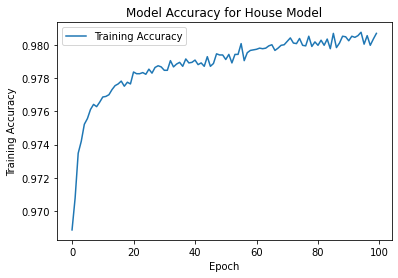

In [34]:
# Plot the accuracy of the training and testing for the senate_model:
plt.plot(fit_model.history['accuracy'])
plt.title('Model Accuracy for House Model')
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.legend(["Training Accuracy"], loc='upper left')
plt.savefig(f'{output_filepath}/house_model_accuracy.png', bbox_inches='tight')
plt.show()

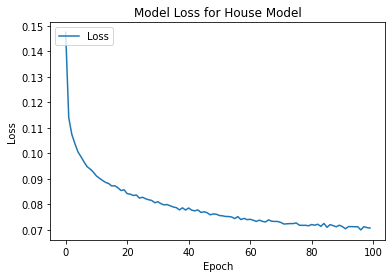

In [35]:
# Plot the accuracy of the training and testing for the house_model:
plt.plot(fit_model.history['loss'])
plt.title('Model Loss for House Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.savefig(f'{output_filepath}/house_model_loss.png', bbox_inches='tight')
plt.show()

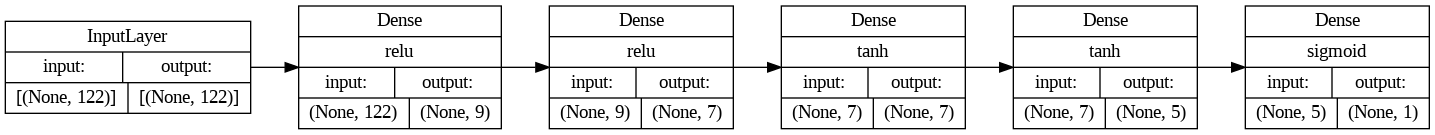

In [36]:

# Load in saved house_model.h5:
house_model = load_model(f'{output_filepath}/house_model.h5')
# Create a visual of the nn model built using the house data:
# Filepath to save image of model visual to:
house_pic_file = f'{output_filepath}/house_model_nn.png'
# LR is horizontal and TB is vertical
tf.keras.utils.plot_model(
    house_model,
    to_file = house_pic_file,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="LR",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)